In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np


## Wczytanie danych

In [2]:
# Wczytaj dane z pliku CSV
predata = pd.read_csv('Prognoza.csv', sep=';' ,parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje tygodniowe 
data = predata.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()
# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())


      DATA_W    ILOSC  articles  customers
0 2022-01-03    7.072         7          3
1 2022-01-04  230.061       415         35
2 2022-01-05  115.141       411         37
3 2022-01-10  148.733       434         47
4 2022-01-11  505.648       896         53
        date    ilosc  articles  customers
0 2022-01-03    7.072         7          3
1 2022-01-04  230.061       415         35
2 2022-01-05  115.141       411         37
3 2022-01-10  148.733       434         47
4 2022-01-11  505.648       896         53


In [3]:
data.describe()

,date,ilosc,articles,customers
count,614,614.000000,614.000000,614.000000
mean,2023-03-24 21:36:56.286644992,638.307425,823.167752,59.705212
min,2022-01-03 00:00:00,-74.035000,1.000000,1.000000
25%,2022-08-13 00:00:00,181.441000,488.500000,52.000000
50%,2023-03-22 12:00:00,259.233000,636.500000,59.000000
75%,2023-11-01 12:00:00,556.146500,862.750000,67.000000
max,2024-06-18 00:00:00,7589.803000,4577.000000,124.000000
std,NaN,1023.765432,634.598299,16.194356


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       614 non-null    datetime64[ns]
 1   ilosc      614 non-null    float64       
 2   articles   614 non-null    int64         
 3   customers  614 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 19.3 KB


# Feature Engineering

In [6]:
# Dodawanie kolumn na podstawie kolumny 'date'
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_year'] = data['date'].dt.dayofyear
data['week_of_year'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter
data['season'] = (data['month'] % 12 // 3) + 1

# Wyświetlanie wyników
print(data[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head())


        date  year  month  day  day_of_year  week_of_year  quarter  season
0 2022-01-03  2022      1    3            3             1        1       1
1 2022-01-04  2022      1    4            4             1        1       1
2 2022-01-05  2022      1    5            5             1        1       1
3 2022-01-10  2022      1   10           10             2        1       1
4 2022-01-11  2022      1   11           11             2        1       1


## Kodowanie cech cyklicznych
Nowe cechy czasowe są cykliczne. Na przykład cecha month cyklicznie przechodzi od 1 do 12 w każdym roku.
Chociaż różnica między każdym miesiącem zwiększa się o 1 w ciągu roku, między dwoma latami cecha month skacze z 12 (grudzień) na 1 (styczeń). To skutkuje różnicą -11, co może wprowadzać zamieszanie w wielu modelach.

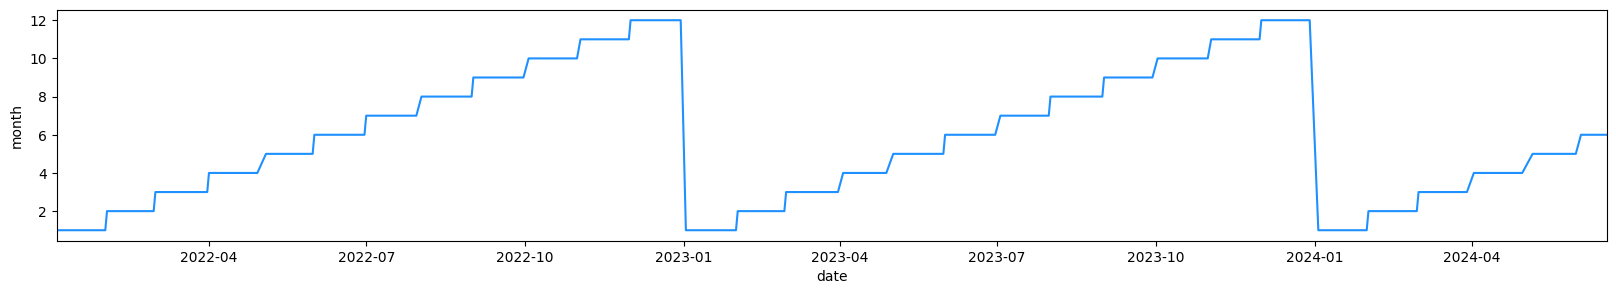

In [13]:
# Automatyczne ustawienie zakresu dat
start_date = data['date'].min()
end_date = data['date'].max()

# Wizualizacja danych
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=data['date'], y=data['month'], color='dodgerblue')
ax.set_xlim([start_date, end_date])
plt.show()

Idealnie, chcemy, aby dane reprezentowały tę samą różnicę między dwoma kolejnymi miesiącami, nawet między grudniem a styczniem. Powszechnym rozwiązaniem tego problemu jest zakodowanie cech cyklicznych w dwóch wymiarach za pomocą transformacji sinusowej i cosinusowej.

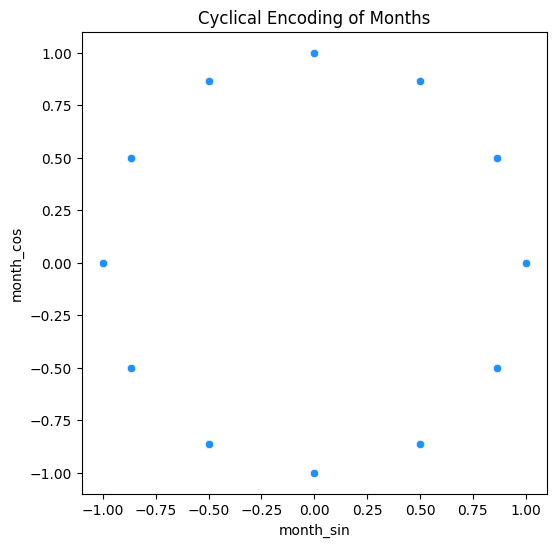

,date,month_sin,month_cos,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,season_sin,season_cos
0,2022-01-03,0.5,0.866025,0.587785,0.809017,0.051620,0.998667,0.120208,0.992749,1.0,6.123234e-17,1.0,6.123234e-17
1,2022-01-04,0.5,0.866025,0.743145,0.669131,0.068802,0.997630,0.120208,0.992749,1.0,6.123234e-17,1.0,6.123234e-17
2,2022-01-05,0.5,0.866025,0.866025,0.500000,0.085965,0.996298,0.120208,0.992749,1.0,6.123234e-17,1.0,6.123234e-17
3,2022-01-10,0.5,0.866025,0.866025,-0.500000,0.171293,0.985220,0.238673,0.9711,1.0,6.123234e-17,1.0,6.123234e-17
4,2022-01-11,0.5,0.866025,0.743145,-0.669131,0.188227,0.982126,0.238673,0.9711,1.0,6.123234e-17,1.0,6.123234e-17


In [11]:
month_in_year = 12
data['month_sin'] = np.sin(2*np.pi*data.month/month_in_year)
data['month_cos'] = np.cos(2*np.pi*data.month/month_in_year)

days_in_month = 30
data['day_sin'] = np.sin(2*np.pi*data.day/days_in_month)
data['day_cos'] = np.cos(2*np.pi*data.day/days_in_month)

days_in_year = 365
data['day_of_year_sin'] = np.sin(2*np.pi*data.day_of_year/days_in_year)
data['day_of_year_cos'] = np.cos(2*np.pi*data.day_of_year/days_in_year)

weeks_in_year = 52.1429
data['week_of_year_sin'] = np.sin(2*np.pi*data.week_of_year/weeks_in_year)
data['week_of_year_cos'] = np.cos(2*np.pi*data.week_of_year/weeks_in_year)

quarters_in_year = 4
data['quarter_sin'] = np.sin(2*np.pi*data.quarter/quarters_in_year)
data['quarter_cos'] = np.cos(2*np.pi*data.quarter/quarters_in_year)

seasons_in_year = 4
data['season_sin'] = np.sin(2*np.pi*data.season/seasons_in_year)
data['season_cos'] = np.cos(2*np.pi*data.season/seasons_in_year)


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=data.month_sin, y=data.month_cos, color='dodgerblue')
plt.title('Cyclical Encoding of Months')
plt.show()


data[['date', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 
            'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'season_sin', 'season_cos']].head()

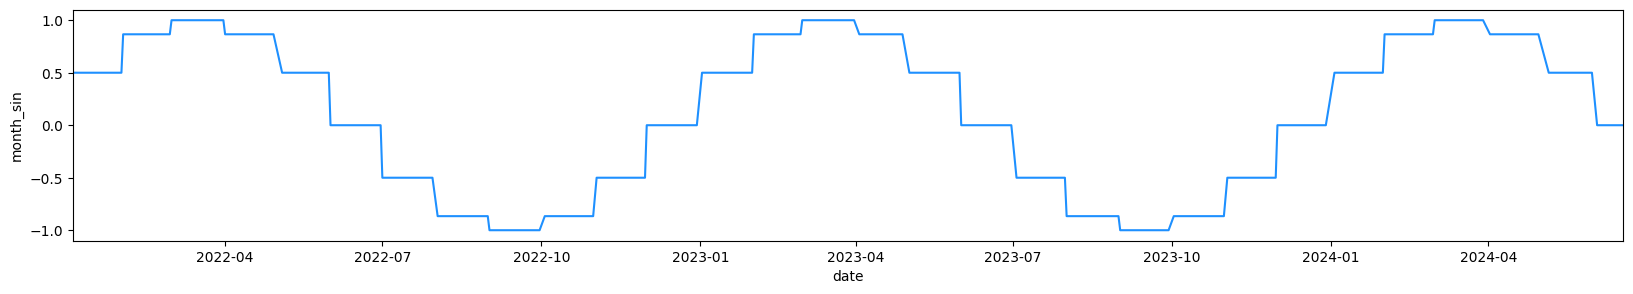

In [14]:
# Automatyczne ustawienie zakresu dat
start_date = data['date'].min()
end_date = data['date'].max()

# Wizualizacja danych
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=data['date'], y=data['month_sin'], color='dodgerblue')
ax.set_xlim([start_date, end_date])
plt.show()

## Dodanie kolumn według wzorca danych

In [28]:
# Dodanie dni według wzorca
data['is_last_days'] = data['day'].isin([28, 29, 30]).astype(int)

# Dodanie dni według wzorca
data['is_first_days'] = data['day'].isin([1, 2, 3, 4, 5]).astype(int)

# Dodanie miesięcy według wzorca
data['is_weak_month'] = data['month'].isin([7, 8, 10, 12]).astype(int)

# Flaga na sobote
data['is_saturday'] = (data['date'].dt.weekday == 5).astype(int)

print(data[['date', 'is_last_days', 'is_first_days', 'is_weak_month', 'is_saturday']].head(5))

# policz ile jest sobót w danych
print(50*'-')
print(data['is_saturday'].sum())

        date  is_last_days  is_first_days  is_weak_month  is_saturday
0 2022-01-03             0              1              0            0
1 2022-01-04             0              1              0            0
2 2022-01-05             0              1              0            0
3 2022-01-10             0              0              0            0
4 2022-01-11             0              0              0            0
--------------------------------------------------
2


## Zastąpienie wartości ujemnych średnią wartością

In [33]:
mean_value = data['ilosc'][data['ilosc'] > 0].mean()
data.loc[data['ilosc'] <= 0, 'ilosc'] = mean_value

## Transformacje danych
### Logarytmowanie i standaryzacja

Logarytmowanie i standaryzacja są powszechnymi metodami przekształcania danych, aby uczynić je bardziej odpowiednimi do modelowania. Logarytmowanie jest szczególnie skuteczne, gdy dane mają dużą rozpiętość wartości, natomiast standaryzacja przekształca dane tak, aby miały średnią równą 0 i odchylenie standardowe równe 1.

* Logarytmowanie: Przekształcimy zmienną ilosc przy użyciu logarytmu naturalnego, co może pomóc w zmniejszeniu wpływu dużych wartości odstających.

* Standaryzacja: Następnie wystandaryzujemy przekształconą zmienną, aby ustabilizować jej wariancję.

In [43]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

# Logarytmowanie zmiennej 'ilosc'
data['ilosc_log'] = np.log(data['ilosc'] + 1)  # Dodanie 1, aby uniknąć log(0)

# Standaryzacja zmiennej 'ilosc_log'
scaler = StandardScaler()
data['ilosc_log_std'] = scaler.fit_transform(data[['ilosc_log']])


# Logarytmowanie zmiennej 'ilosc'
data['customers_log'] = np.log(data['customers'] + 1)  # Dodanie 1, aby uniknąć log(0)

# Standaryzacja zmiennej 'ilosc_log'
scaler = StandardScaler()
data['customers_log_std'] = scaler.fit_transform(data[['customers_log']])

# Logarytmowanie zmiennej 'ilosc'
data['articles_log'] = np.log(data['articles'] + 1)  # Dodanie 1, aby uniknąć log(0)

# Standaryzacja zmiennej 'ilosc_log'
scaler = StandardScaler()
data['articles_log_std'] = scaler.fit_transform(data[['articles_log']])

# Wyświetlenie podstawowych statystyk po transformacji
print(data[['ilosc', 'ilosc_log', 'ilosc_log_std']].describe())

# Test stacjonarności (ADF Test)

from statsmodels.tsa.stattools import adfuller

# Funkcja do przeprowadzenia testu ADF i wyświetlenia wyników
def adfuller_test(series, column_name):
    result = adfuller(series)
    adf_stat = result[0]
    p_val = result[1]
    crit_values = result[4]
    
    print(f"Wyniki testu ADF dla {column_name}:")
    print(f"Statystyka ADF: {adf_stat}")
    print(f"Wartość p: {p_val}")
    print("Wartości krytyczne:")
    for key, value in crit_values.items():
        print(f"{key}: {value}")
    print("-" * 50)

# Przeprowadź test ADF dla każdej z kolumn
for column in ['ilosc_log_std', 'customers_log_std', 'articles_log_std']:
    adfuller_test(data[column].values, column)

             ilosc   ilosc_log  ilosc_log_std
count   614.000000  614.000000   6.140000e+02
mean    639.469485    5.833309  -5.786179e-18
std    1023.360409    1.035608   1.000815e+00
min       0.221000    0.199670  -5.444369e+00
25%     182.104000    5.210054  -6.023155e-01
50%     260.117000    5.564965  -2.593281e-01
75%     556.920000    6.324216   4.744141e-01
max    7589.803000    8.934693   2.997189e+00
Wyniki testu ADF dla ilosc_log_std:
Statystyka ADF: -6.063788864987532
Wartość p: 1.1951500570655538e-07
Wartości krytyczne:
1%: -3.441406876071572
5%: -2.866418015869717
10%: -2.5693678601956718
--------------------------------------------------
Wyniki testu ADF dla customers_log_std:
Statystyka ADF: -3.9425012696167445
Wartość p: 0.0017433978694610312
Wartości krytyczne:
1%: -3.441277537487585
5%: -2.8663610578661083
10%: -2.5693375106104357
--------------------------------------------------
Wyniki testu ADF dla articles_log_std:
Statystyka ADF: -23.529396886709236
Wartość p: 0

#### Funkcja eksponencjalna
Po przekształceniu danych logarytmem, prognozy będą w skali logarytmicznej. Aby uzyskać prognozy w oryginalnej skali danych, należy przekształcić prognozowane wartości z powrotem poprzez eksponencjalizację. Jest to kluczowe dla interpretacji wyników w kontekście oryginalnych danych.

Kroki:
* Przekształcenie prognoz z powrotem do oryginalnej skali: Używamy funkcji eksponencjalnej.
* Porównanie przekształconych prognoz z oryginalnymi danymi.

In [ ]:
# Najpierw musimy odwrócić standaryzację
data['ilosc_log_reversed'] = scaler.inverse_transform(data[['ilosc_log_std']])

# Następnie musimy odwrócić logarytmowanie
data['ilosc_reversed'] = np.exp(data['ilosc_log_reversed']) - 1

## Zmienne odstające

In [40]:
# Funkcja do wykrywania wartości odstających
def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    for i in range(len(data)):
        z_score = (data[i] - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

# Wykrywanie wartości odstających w zestawie treningowym
outliers_indices = detect_outliers(data['ilosc'], 2)

# Wyświetlenie dat, w których występują wartości odstające
outliers_dates = data.iloc[outliers_indices]['date']
##print(f"Dates with outliers: {outliers_dates}")

# Wyświetlenie wartości odstających
outliers_values = data.iloc[outliers_indices]['ilosc']
##print(f"Outlier values: {outliers_values}")

# Łączenie dat z wartościami odstającymi w jednym DataFrame
outliers_info = pd.DataFrame({
    'Date': outliers_dates,
    'Outlier Value': outliers_values
})
print(outliers_info)

          Date  Outlier Value
11  2022-01-20       2824.822
19  2022-01-31       3785.288
38  2022-02-25       5276.154
52  2022-03-17       3993.249
61  2022-03-30       3475.225
81  2022-04-28       4507.516
82  2022-04-29       2712.775
101 2022-05-30       3585.725
120 2022-06-28       4966.975
144 2022-07-30       5023.109
164 2022-08-30       4435.912
187 2022-09-30       3410.914
207 2022-10-28       5648.981
227 2022-11-29       7426.484
228 2022-11-30       4232.592
265 2023-01-24       3757.663
287 2023-02-23       5507.762
309 2023-03-27       5631.080
330 2023-04-26       6132.750
352 2023-05-30       3185.715
372 2023-06-29       2716.532
388 2023-07-21       3627.494
415 2023-08-30       2806.037
435 2023-09-27       2783.716
457 2023-10-27       2753.881
478 2023-11-29       7589.803
489 2023-12-14       2944.383
517 2024-01-29       2780.843
519 2024-01-31       3689.816
540 2024-02-29       5476.822
560 2024-03-28       4616.911
581 2024-04-29       6091.644
600 2024-0

In [ ]:
# Wybór kolumn do stworzenia histogramów
columns_to_plot = ['ilosc', 'ilosc_imputacja']

# Tworzenie histogramów dla wybranych kolumn
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Histogram dla {column}')
    plt.xlabel(column)
    plt.ylabel('Częstotliwość')

plt.tight_layout()
plt.show()

## Zapis danych

In [44]:
## Zapisanie danych po tranformacji do pliku CSV
data.to_csv('Prognoza_transformed.csv', index=False)